### this notebook best viewed here: http://nbviewer.jupyter.org

#### Purpose
To see if misalignments due to potential paralogs are causing false variation in our data (false positive SNPs), we used megagametophyte (haploid) data and called SNPs (hereafter megaSNPs) with our poolSeq caller. Any SNP that returns called as heterozygote is a candidate region for paralogs since a haploid genotype cannot be heterozygote (ie it has to be monoallelic). Since VarScan will be our poolSeq SNP caller, we will use VarScan to call megaSNPs.

To validate that what we're seeing from VarScan megaSNPs is following expectations of patterns from paralogs, we investigate read ratio deviations from a bionomial expectation for these VarScan poolSeq megaSNP sites at the same sites in our GATK indSeq data using heterozygote diploid individuals (sensu McKinney et al 2017 Mol Ecol Res, see also Rellstab et al 2018 Mol Ecol Res). Heterozygote individuals should have, more or less, an even ratio of REF and ALT alleles. If the site is a misalignment (false positive SNP) the read ratio will significantly differ from this expectation.

If we are sequencing (and then post-hoc correctly identifying) paralogs using megaSNP sites, divergence between paralogs will cause read ratio deviations in these loci from our data (and affect allele freq estimates, and downstream analyses). We therefore look for these deviations within the GATK indSeq data in heterozygote individuals for sites called heterozygote from the VarScan megaSNP run.

- I follow the method from McKinney et al 2017 Mol Ecol Res (see also Rellstab et al 2018 Mol Ecol Res) to identify significant read ratio deviations, and compare to expected deviations from diverged paralogs (expectations from McKinney et al). Once validated, I'll see how these SNPs affect allele frequency correspondence between indSeq and poolSeq data.

#### Notebook outline
two main sections:
- look at GATK indSeq data for loci intersecting indSeq and poolSeq (from 002_testdata_compare_AFs.ipynb)
- look at GATK indSeq data as a whole - just the baseline-filtered GATK SNPs before filtering for intersection between poolSeq or megaSNPs

for each section:
- load in GATK diploid data, load in VarScan megagametophyte data
- calculate read ratio statistics sensu McKinney et al 2017 Mol Ecol Res
- plot figures (compare to expectations from McKinney et al 2017 Mol Ecol Res)
    - read ratio z-score vs percentage of heterozygotes (hetPerc)
    - raw read ratio vs hetPerc
    - allelic ratio vs ALT freq
    - allelic ratio vs binned ALT freq

#### Conclusions (out of order with code)
- the indSeq SNPs that intersect heterozygotic megaSNPs (captured using haploid megagametophyte tissue; SNPs due to misalignment) follow expectations from diverged paralogs
- this means that we need to think about these positions in future analyses of our poolSeq data since these indSeq/megaSNPs are also found in our poolSeq SNP sets

#### Personal notes for records

HD method here:

- cedar: notebooks/old_notebooks/04_comparing_allele_freqs_DF.ipynb
- yeaman03: notebooks/001_mega-varscan_explore.ipynb

In [1]:
from pythonimports import *
from IPython.display import Image
methodsdir = '/data/home/lindb/methods_paper_analysis'
firstdir = op.join(methodsdir, '001_testdata_explore')
secdir = op.join(methodsdir, '002_testdata_compare_AFs')
thirddir = makedir(op.join(methodsdir, '003_testdata_validate_megaSNPs'))

def get_realfreqs(df, ploidy=40):
    """Round AF column to nearest possible freq given data."""
    # first create all possible allele freqs for ploidy=40
    realfreqs = [x/ploidy for x in range(0,ploidy+1,1)]

    # iterate through realfreqs, get cutoffs on either side of realfreq
    freqcutoffs = []
    for i,freq in enumerate(realfreqs):
        if i==0:
            lastcut = round((freq+realfreqs[i+1])/2, 4)
            freqcutoffs.append([0, lastcut])  # next step rounds any AF > 0 to 0.025
        elif i+1 < len(realfreqs):
            newcut = round((freq+realfreqs[i+1])/2, 4)
            freqcutoffs.append([lastcut, newcut])  # lower and upper thresholds to bin at freq 
            lastcut = newcut
        else:
            freqcutoffs.append([lastcut, 1.0])  # lower and upper thresholds to bin at freq

    # fill in the realfreq column
    df['realfreq'] = np.nan
    for i,(lowfreq,hifreq) in enumerate(freqcutoffs):
        if lowfreq == 0:
            freq = 1/ploidy  #  because there are no loci fixed for REF (pre-filter)
        elif (i+1) < len(freqcutoffs):
            freq = round((lowfreq + hifreq) / 2, 3)
        else:
            freq = 1.0
        df.loc[(df['AF'] > lowfreq) & (df['AF'] <= hifreq), 'realfreq'] = freq
    return df

# <center> GATK indSeq data for loci intersecting indSeq and poolSeq

# load data 

In [2]:
# load in snps (includes the gatk indSeq data) - from first part of 002_testdata_compare_AFs.ipynb
snps = pklload(op.join(secdir, 'snps_dict_intersecting_no-noREFloci_realfreqs.pkl'))
varscan = [snps.pop(method) for method in list(snps.keys()) if method != 'gatk']  # remove poolseq data
del varscan
for sp,df in snps['gatk'].items():
    print(sp, nrow(df))

JP 255706
DF 636279


In [3]:
snps['gatk']['JP'].head()

,CHROM,POS,REF,ALT,AF,DP,QD,FS,MQ,MQRankSum,ReadPosRankSum,TYPE,FILTER,JP_101_10_cap4_kit1.AD,JP_101_10_cap4_kit1.DP,JP_101_10_cap4_kit1.GQ,JP_101_10_cap4_kit1.GT,JP_101_10_cap4_kit1.SB,JP_101_11_cap4_kit1.AD,JP_101_11_cap4_kit1.DP,JP_101_11_cap4_kit1.GQ,JP_101_11_cap4_kit1.GT,JP_101_11_cap4_kit1.SB,JP_101_12_cap4_kit1.AD,JP_101_12_cap4_kit1.DP,JP_101_12_cap4_kit1.GQ,JP_101_12_cap4_kit1.GT,JP_101_12_cap4_kit1.SB,JP_101_13_cap4_kit1.AD,JP_101_13_cap4_kit1.DP,JP_101_13_cap4_kit1.GQ,JP_101_13_cap4_kit1.GT,JP_101_13_cap4_kit1.SB,JP_101_14_cap5_kit1.AD,JP_101_14_cap5_kit1.DP,JP_101_14_cap5_kit1.GQ,JP_101_14_cap5_kit1.GT,JP_101_14_cap5_kit1.SB,JP_101_15_cap5_kit1.AD,JP_101_15_cap5_kit1.DP,JP_101_15_cap5_kit1.GQ,JP_101_15_cap5_kit1.GT,JP_101_15_cap5_kit1.SB,JP_101_16_cap5_kit1.AD,JP_101_16_cap5_kit1.DP,JP_101_16_cap5_kit1.GQ,JP_101_16_cap5_kit1.GT,JP_101_16_cap5_kit1.SB,JP_101_17_cap5_kit1.AD,JP_101_17_cap5_kit1.DP,...,JP_101_20_cap5_kit1.GQ,JP_101_20_cap5_kit1.GT,JP_101_20_cap5_kit1.SB,JP_101_2_cap3_kit1.AD,JP_101_2_cap3_kit1.DP,JP_101_2_cap3_kit1.GQ,JP_101_2_cap3_kit1.GT,JP_101_2_cap3_kit1.SB,JP_101_3_cap3_kit1.AD,JP_101_3_cap3_kit1.DP,JP_101_3_cap3_kit1.GQ,JP_101_3_cap3_kit1.GT,JP_101_3_cap3_kit1.SB,JP_101_4_cap3_kit1.AD,JP_101_4_cap3_kit1.DP,JP_101_4_cap3_kit1.GQ,JP_101_4_cap3_kit1.GT,JP_101_4_cap3_kit1.SB,JP_101_5_cap3_kit1.AD,JP_101_5_cap3_kit1.DP,JP_101_5_cap3_kit1.GQ,JP_101_5_cap3_kit1.GT,JP_101_5_cap3_kit1.SB,JP_101_6_cap3_kit1.AD,JP_101_6_cap3_kit1.DP,JP_101_6_cap3_kit1.GQ,JP_101_6_cap3_kit1.GT,JP_101_6_cap3_kit1.SB,JP_101_7_cap4_kit1.AD,JP_101_7_cap4_kit1.DP,JP_101_7_cap4_kit1.GQ,JP_101_7_cap4_kit1.GT,JP_101_7_cap4_kit1.SB,JP_101_8_cap4_kit1.AD,JP_101_8_cap4_kit1.DP,JP_101_8_cap4_kit1.GQ,JP_101_8_cap4_kit1.GT,JP_101_8_cap4_kit1.SB,JP_101_9_cap4_kit1.AD,JP_101_9_cap4_kit1.DP,JP_101_9_cap4_kit1.GQ,JP_101_9_cap4_kit1.GT,JP_101_9_cap4_kit1.SB,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF,realfreq,realMAF
>super4-47333,Scaffold_1,47333,G,A,0.225,247,18.16,1.640,60.0,0.0,0.185,SNP,PASS,"9,0",9.0,24.0,G/G,NaN,"8,0",8.0,24.0,G/G,NaN,"10,7",17.0,99.0,G/A,NaN,"10,0",10.0,30.0,G/G,NaN,"8,0",8.0,24.0,G/G,NaN,"10,0",10.0,27.0,G/G,NaN,"12,0",12.0,36.0,G/G,NaN,"9,0",9.0,...,0.0,./.,NaN,"9,0",9.0,27.0,G/G,NaN,"18,0",18.0,51.0,G/G,NaN,"5,5",10.0,99.0,G/A,NaN,"17,0",17.0,39.0,G/G,NaN,"0,11",11.0,33.0,A/A,NaN,"9,8",17.0,99.0,G/A,NaN,"0,13",13.0,39.0,A/A,NaN,"10,0",10.0,30.0,G/G,NaN,Scaffold_1-47333,>super4,47333,>super4-47333,0.225,0.225,0.225
>super4-47395,Scaffold_1,47395,A,C,1.000,239,31.04,0.000,60.0,NaN,NaN,SNP,PASS,"0,10",10.0,30.0,C/C,NaN,"0,9",9.0,27.0,C/C,NaN,"0,13",13.0,39.0,C/C,NaN,"0,13",13.0,39.0,C/C,NaN,"0,5",5.0,15.0,./.,NaN,"0,8",8.0,24.0,C/C,NaN,"0,12",12.0,36.0,C/C,NaN,"0,10",10.0,...,57.0,C/C,NaN,"0,9",9.0,27.0,C/C,NaN,"0,16",16.0,48.0,C/C,NaN,"0,9",9.0,27.0,C/C,NaN,"0,14",14.0,42.0,C/C,NaN,"0,9",9.0,27.0,C/C,NaN,"0,12",12.0,36.0,C/C,NaN,"0,20",20.0,60.0,C/C,NaN,"0,9",9.0,27.0,C/C,NaN,Scaffold_1-47395,>super4,47395,>super4-47395,0.000,1.000,0.000
>super4-47418,Scaffold_1,47418,T,A,0.075,236,10.75,1.242,60.0,0.0,0.184,SNP,PASS,"12,0",12.0,33.0,T/T,NaN,"8,0",8.0,21.0,T/T,NaN,"12,0",12.0,36.0,T/T,NaN,"11,0",11.0,30.0,T/T,NaN,"5,0",5.0,0.0,./.,NaN,"11,0",11.0,33.0,T/T,NaN,"13,0",13.0,39.0,T/T,NaN,"11,0",11.0,...,99.0,T/A,NaN,"12,0",12.0,0.0,./.,NaN,"10,5",15.0,99.0,T/A,NaN,"6,3",9.0,81.0,T/A,NaN,"13,0",13.0,33.0,T/T,NaN,"11,0",11.0,30.0,T/T,NaN,"12,0",12.0,33.0,T/T,NaN,"19,0",19.0,51.0,T/T,NaN,"7,0",7.0,21.0,T/T,NaN,Scaffold_1-47418,>super4,47418,>super4-47418,0.075,0.075,0.075
>super4-47480,Scaffold_1,47480,G,A,1.000,240,28.60,0.000,60.0,NaN,NaN,SNP,PASS,"0,12",12.0,36.0,A/A,NaN,"0,11",11.0,32.0,A/A,NaN,"0,8",8.0,24.0,A/A,NaN,"0,8",8.0,24.0,A/A,NaN,"0,10",10.0,29.0,A/A,NaN,"0,14",14.0,42.0,A/A,NaN,"0,13",13.0,39.0,A/A,NaN,"0,12",12.0,...,63.0,A|A,NaN,"0,15",15.0,45.0,A/A,NaN,"0,12",12.0,36.0,A|A,NaN,"0,9",9.0,27.0,A/A,NaN,"0,14",14.0,42.0,A/A,NaN,"0,12",12.0,36.0,A/A,NaN,"0,7",7.0,21.0,A/A,NaN,"0,15",15.0,45.0,A/

In [4]:
# load megaSNPs
megafiles = {'JP': '/data/projects/pool_seq/non-pangenome/varscan_mega/JP_RFmg7/snpsANDindels/JP_RFmg7-varscan_all_bedfiles_SNP_paralog_snps_translated.txt',
             'DF': '/data/projects/pool_seq/non-pangenome/varscan_mega/DF_megaSNPs_from_download/DF_mega/snpsANDindels/02_baseline_filtered/DF_mega-varscan_all_bedfiles_SNP_paralog_snps.txt'}
megasnps = {}
for sp,file in megafiles.items():
    megasnps[sp] = pd.read_table(file)
    locuscol = 'unstitched_locus' if 'unstitched_locus' in megasnps[sp].columns else 'locus'
    if locuscol == 'locus':
        loci = [">%s" % locus for locus in megasnps[sp][locuscol].tolist()]
    else:
        loci = megasnps[sp][locuscol].tolist()
    megasnps[sp].index = loci
    print(sp)
    display(megasnps[sp].head())

JP


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_RFmg7.GT,JP_RFmg7.GQ,JP_RFmg7.SDP,JP_RFmg7.DP,JP_RFmg7.FREQ,JP_RFmg7.PVAL,locus,unstitched_chrom,unstitched_pos,unstitched_locus
>super27-173057,Scaffold_2,173057,C,T,0.7778,-10.0,SNP,PASS,9,0,1,0,0,C/T,29,9,9,77.78%,0.001131,Scaffold_2-173057,>super27,173057,>super27-173057
>super27-174201,Scaffold_2,174201,T,C,0.7000,-10.0,SNP,PASS,10,0,1,0,0,T/C,28,10,10,70%,0.001548,Scaffold_2-174201,>super27,174201,>super27-174201
>super27-174218,Scaffold_2,174218,C,T,0.6667,-10.0,SNP,PASS,9,0,1,0,0,C/T,23,9,9,66.67%,0.004525,Scaffold_2-174218,>super27,174218,>super27-174218
>super27-574293,Scaffold_2,574293,C,T,0.4615,-10.0,SNP,PASS,13,0,1,0,0,C/T,21,13,13,46.15%,0.007453,Scaffold_2-574293,>super27,574293,>super27-574293
>super27-574357,Scaffold_2,574357,A,C,0.5455,-10.0,SNP,PASS,11,0,1,0,0,A/C,22,11,11,54.55%,0.006192,Scaffold_2-574357,>super27,574357,>super27-574357


DF


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_mega.GT,DF_mega.GQ,DF_mega.SDP,DF_mega.DP,DF_mega.FREQ,DF_mega.PVAL,DF_mega.AD,DF_mega.RD,locus
>jcf7190000000008-199707,jcf7190000000008,199707,T,A,0.5000,-10.0,SNP,PASS,12,0,1,0,0,T/A,21,12,12,50%,0.006865,6,6,jcf7190000000008-199707
>jcf7190000000008-199711,jcf7190000000008,199711,G,A,0.5000,-10.0,SNP,PASS,12,0,1,0,0,G/A,21,12,12,50%,0.006865,6,6,jcf7190000000008-199711
>jcf7190000000008-199767,jcf7190000000008,199767,T,G,0.5000,-10.0,SNP,PASS,12,0,1,0,0,T/G,21,12,12,50%,0.006865,6,6,jcf7190000000008-199767
>jcf7190000000008-199784,jcf7190000000008,199784,A,T,0.6667,-10.0,SNP,PASS,9,0,1,0,0,A/T,23,9,9,66.67%,0.004525,6,3,jcf7190000000008-199784
>jcf7190000000008-207192,jcf7190000000008,207192,A,C,0.7500,-10.0,SNP,PASS,8,0,1,0,0,A/C,24,8,8,75%,0.003497,6,2,jcf7190000000008-207192


In [5]:
# how many intersecting?
print('sp mega total_mega')
print('------------------')
inters = {}
for sp in ['JP', 'DF']:
    inters[sp] = list(set(snps['gatk'][sp].index.tolist()).intersection(megasnps[sp].index.tolist()))
    print(sp, len(inters[sp]), nrow(megasnps[sp]))

sp mega total_mega
------------------
JP 7006 32751
DF 248 398774


# calculate read ratio deviations

In [6]:
# create function to get allele balance
# modified from https://datadryad.org/resource/doi:10.5061/dryad.cm08m
# in dryad code, they query the vcf, but I have that in the table so I don't need to query

def get_het_depths(df, wantedloci, outfile):
    """Get allele depth stats from heterozygote individuals for specific loci of interest.
    
    modified from https://datadryad.org/resource/doi:10.5061/dryad.cm08m
    
    This is basically the dryad's vcf_to_allele_depth() from vcf_to_depth.py.
    """
    
    # get a list of samples
    samps = [col.split(".")[0] for col in df.columns if '.AD' in col]

    # reduce df to wantedloci
    df = df.loc[wantedloci, :].copy()
    
    # get depth info
    lines = []
    for locus in nb(df.index):
        chrom,pos = locus.split("-")
        AF = df.loc[locus, 'AF']
        depth_a_of_ind, depth_b_of_ind = [],[]
        total_depth_a, total_depth_b = 0,0
        for samp in samps:
            if df.loc[locus, f'{samp}.GT'] not in ['A/A','T/T','G/G','C/C']: # assumes biallelic
                refdepth,altdepth = [int(dp) for dp in df.loc[locus, f'{samp}.AD'].split(",")]
                depth_a_of_ind.append(refdepth)
                depth_b_of_ind.append(altdepth) 
                total_depth_a += refdepth
                total_depth_b += altdepth
        num_hets = len(depth_a_of_ind)
        num_samples = len(samps)
        sum_a = sum(depth_a_of_ind)
        sum_b = sum(depth_b_of_ind)
        if sum_a+sum_b > 0:
            line = '\t'.join([str(x) for x in [chrom, pos, locus, AF, sum_a, sum_b , 
                                               sum_a/(sum_a+sum_b),
                                               num_hets, num_samples,
                                               total_depth_a, total_depth_b, 
                                               total_depth_a/(total_depth_a+total_depth_b),
                                               total_depth_b/(total_depth_a+total_depth_b)]])
            lines.append(line)

    with open(outfile, 'w') as o:
        header = '\t'.join(['CHROM', 'POS', 'locus_ID', 'AF', 'HET_REF_AD', 'HET_ALT_AD', 
                    'HET_REF_AD-div-HET_DP',
                    'num_hets', 'num_samples',
                    'TOTAL_REF_AD','TOTAL_ALT_AD',
                    'TOTAL_REF_AD-div-TOTAL_DP','TOTAL_ALT_AD-div-TOTAL_DP'])
        o.write("%s\n" % header)
        o.write("%s" % '\n'.join(lines))
    return outfile

def get_z_scores(df):
    """Use read ratio statistics to calculate z-scores."""
    from scipy.stats import binom
    # modified from https://datadryad.org/resource/doi:10.5061/dryad.cm08m : HDplot_python.py
    #SUM READ COUNTS PER LOCUS
    df['HET-TOTAL_AD'] = df['HET_REF_AD'] + df['HET_ALT_AD']
    #CALCULATE HETEROZYGOSITY perc
    df['hetPerc'] = [df.loc[row,'num_hets']/df.loc[row,'num_samples'] for row in df.index]
    #CALCULATE EXPECTED STANDARD DEVIATION BASED ON BINOMIAL DISTRIBUTION
    df['std'] = binom(n = df['HET-TOTAL_AD'], p = .5).std()
    #CALCULATE Z-SCORE BASED ON STANDARD DEVIATION
    df['z'] = (df['HET_REF_AD'] - (df['HET-TOTAL_AD']/2))/ df['std']
    # (mine) add in MAF so I don't have to use a dict
    df['MAF'] = [1-round(float(af),3) if round(float(af),3) > 0.5 else round(float(af),3) for af in df['AF']]
    return df

In [7]:
# for each of the diploid datasets, calculate read ratio stats **for loci overlapping with megaSNPS** ...
# ... and write to file, capture file in list(outs)
outs = []
for sp in ['JP', 'DF']:
    outfile = op.join(thirddir, f'AD_depths-{sp}.txt')
#     if op.exists(outfile):
#         outs.append(outfile)
#     else:
    outs.append(get_het_depths(snps['gatk'][sp], inters[sp], outfile))
outs

100%|██████████| 248/248 [00:00<00:00, 3877.30it/s]


['/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/AD_depths-JP.txt',
 '/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/AD_depths-DF.txt']

In [8]:
# read in the AlleleDepth output from list(outs)
ads = {}
for out in outs:
    sp = out.split("-")[-1].split('.txt')[0]
    ads[sp] = pd.read_table(out)
    ads[sp].index = ads[sp]['locus_ID'].tolist()
    print(sp, ads[sp].shape)

JP (7006, 13)
DF (246, 13)


In [9]:
# get z scores for each species (I could have grabbed this during get_het_depths() but forgot to code it)
for sp,df in ads.items():
    df = get_realfreqs(get_z_scores(df))
ads[sp].head()

,CHROM,POS,locus_ID,AF,HET_REF_AD,HET_ALT_AD,HET_REF_AD-div-HET_DP,num_hets,num_samples,TOTAL_REF_AD,TOTAL_ALT_AD,TOTAL_REF_AD-div-TOTAL_DP,TOTAL_ALT_AD-div-TOTAL_DP,HET-TOTAL_AD,hetPerc,std,z,MAF,realfreq
>jcf7190000176200-564,>jcf7190000176200,564,>jcf7190000176200-564,0.500,4944,2807,0.637853,20,20,4944,2807,0.637853,0.362147,7751,1.00,44.019882,24.273123,0.500,0.500
>jcf7190000011246-471806,>jcf7190000011246,471806,>jcf7190000011246-471806,0.700,36,189,0.160000,13,20,36,189,0.160000,0.840000,225,0.65,7.500000,-10.200000,0.300,0.700
>jcf7190000006005-327604,>jcf7190000006005,327604,>jcf7190000006005-327604,0.575,141,275,0.338942,17,20,141,275,0.338942,0.661058,416,0.85,10.198039,-6.569891,0.425,0.575
>jcf7190000012300-146226,>jcf7190000012300,146226,>jcf7190000012300-146226,0.550,201,1133,0.150675,18,20,201,1133,0.150675,0.849325,1334,0.90,18.261982,-25.517493,0.450,0.550
>jcf7190000028512-6993,>jcf7190000028512,6993,>jcf7190000028512-6993,0.500,402,561,0.417445,20,20,402,561,0.417445,0.582555,963,1.00,15.516121,-5.123703,0.500,0.500


# Make Figures

#### intersection I1 - megaSNPs, indSeq and poolSeq SNPs
- gatk loci intersecting poolSeq SNPs (from 002_testdata_compare_AFs.ipynb) that also intersect megaSNPs 
- megaSNP intsxn. done above to create "ads" object used here

In [10]:
??makesweetgraph

In [11]:
#figdir = makedir(op.join(thirddir, 'figures'))
figdir = makedir(op.join(thirddir, 'updated_figures'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i1_JP.pdf


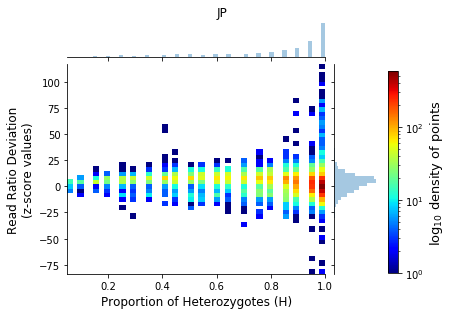

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i1_DF.pdf


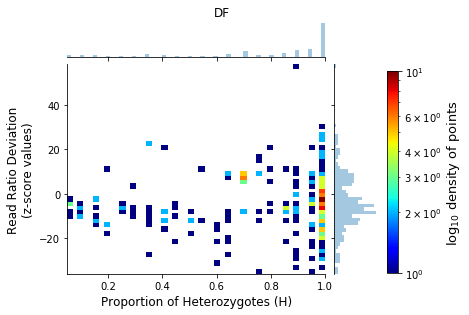

In [12]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i1'  # intersection
for sp,df in ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=sp, bins=49,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}.pdf')
                  )

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i1_JP_ylim2.pdf


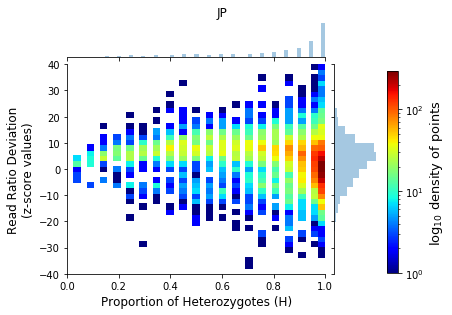

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i1_DF_ylim2.pdf


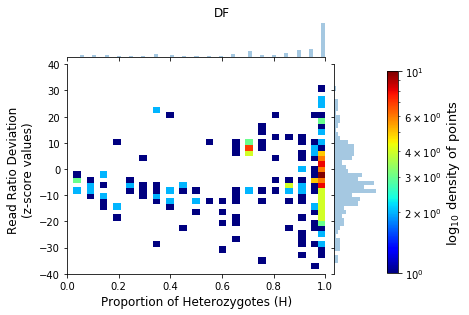

In [13]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i1'  # intersection
for sp,df in ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=sp, bins=39,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}_ylim2.pdf'), xlim=(0,1), ylim=(-40,40)
                  )

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-H_i1_JP.pdf


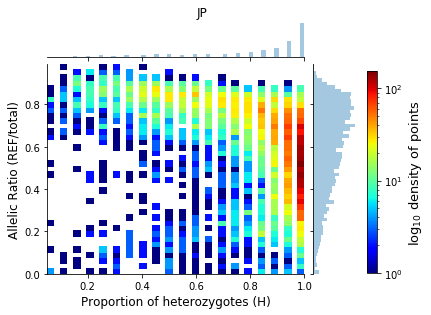

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-H_i1_DF.pdf


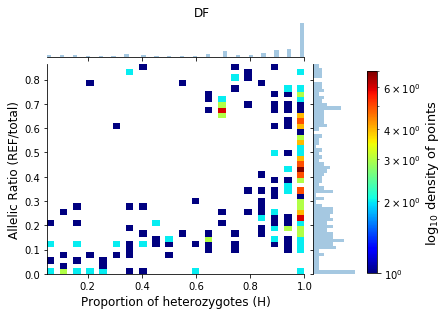

In [14]:
#PLOT RATIO AGAINST HETEROZYGOSITY
ixn = 'i1'  # intersection
for sp,df in ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['HET_REF_AD-div-HET_DP'],xlab='Proportion of heterozygotes (H)',
                   ylab='Allelic Ratio (REF/total)', title=sp, bins=39,
                   saveloc=op.join(figdir, f'AR-vs-H_{ixn}_{sp}.pdf'))

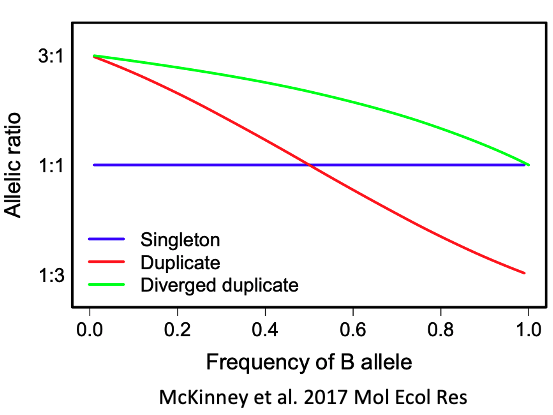

In [15]:
# show expectations from McKinney et al 2017 Mol Ecol Res
Image(filename=op.join(methodsdir, 'figs/all-ratio_vs_ALT-freq.png'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-ALT_i1_JP.pdf


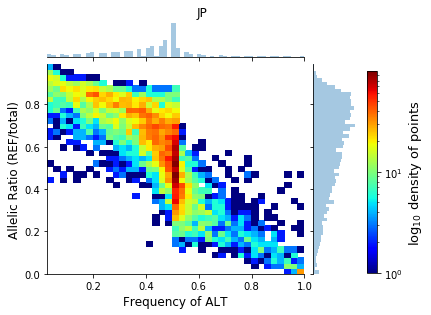

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-ALT_i1_DF.pdf


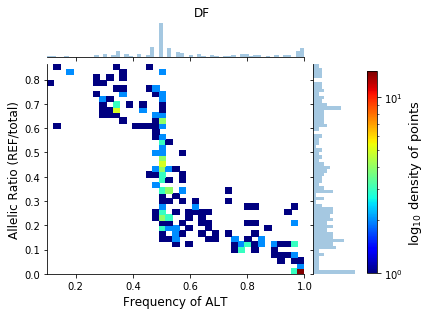

In [16]:
# RR vs AF
ixn = 'i1'  # intersection
for sp,df in ads.items():
    makesweetgraph(x=df['AF'],y=df['HET_REF_AD-div-HET_DP'],
                   ylab='Allelic Ratio (REF/total)',xlab='Frequency of ALT', title=sp, bins=39,
                   saveloc=op.join(figdir, f'AR-vs-ALT_{ixn}_{sp}.pdf'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/H-vs-ALT_i1_JP.pdf


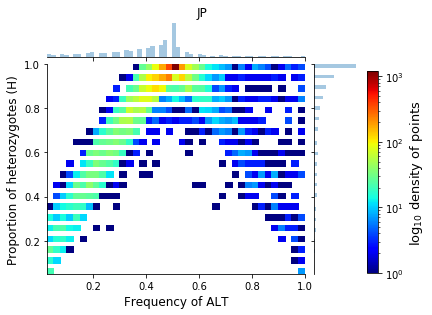

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/H-vs-ALT_i1_DF.pdf


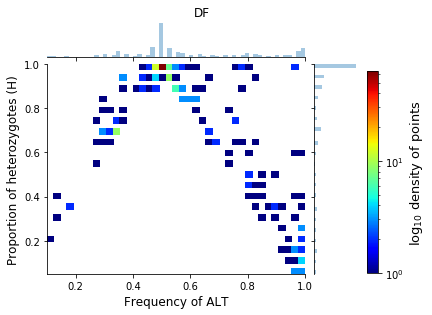

In [17]:
# AF vs hetPerc
ixn = 'i1'  # intersection
for sp,df in ads.items():
    makesweetgraph(x=df['realfreq'],y=df['hetPerc'],
                   ylab='Proportion of heterozygotes (H)',xlab='Frequency of ALT', title=sp, bins=39,
                   saveloc=op.join(figdir, f'H-vs-ALT_{ixn}_{sp}.pdf'))

#### look at all SNPs that intersect indSeq and poolSeq (from 002_testdata_compare_AFs.ipynb)

- ie, use SNPs that intersect indSeq and poolSeq methods without further filtering for intersection with megaSNPs 
- see complete GATK data in next section = baseline-filtered GATK output before intesection with poolSeq or megaSNPs

In [18]:
# use diploid loci to get allele ratio statitistics
all_outs = []
for sp in ['JP', 'DF']:
    outfile = op.join(thirddir, f'AD_depths-{sp}_all-loci.txt')
#     if op.exists(outfile):
#         all_outs.append(outfile)
#     else:
    all_outs.append(get_het_depths(snps['gatk'][sp], snps['gatk'][sp].index, outfile))
all_outs

100%|██████████| 636279/636279 [02:26<00:00, 4340.83it/s]


['/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/AD_depths-JP_all-loci.txt',
 '/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/AD_depths-DF_all-loci.txt']

In [19]:
all_outs = ['/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/AD_depths-JP_all-loci.txt',
 '/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/AD_depths-DF_all-loci.txt']

In [20]:
# read in the output
all_ads = {}
for out in all_outs:
    sp = out.split("-")[-2]
    all_ads[sp] = pd.read_table(out)
    all_ads[sp].index = all_ads[sp]['locus_ID'].tolist()
    print(sp, all_ads[sp].shape)

JP_all (253812, 13)
DF_all (630529, 13)


In [21]:
# get z scores for each species, add realfreq column
for sp,df in all_ads.items():
    df = get_realfreqs(get_z_scores(df))
all_ads[sp].head()

,CHROM,POS,locus_ID,AF,HET_REF_AD,HET_ALT_AD,HET_REF_AD-div-HET_DP,num_hets,num_samples,TOTAL_REF_AD,TOTAL_ALT_AD,TOTAL_REF_AD-div-TOTAL_DP,TOTAL_ALT_AD-div-TOTAL_DP,HET-TOTAL_AD,hetPerc,std,z,MAF,realfreq
>jcf7190000000004-54540,>jcf7190000000004,54540,>jcf7190000000004-54540,0.500,71,74,0.489655,13,20,71,74,0.489655,0.510345,145,0.65,6.020797,-0.249136,0.500,0.500
>jcf7190000000004-54587,>jcf7190000000004,54587,>jcf7190000000004-54587,0.275,92,61,0.601307,15,20,92,61,0.601307,0.398693,153,0.75,6.184658,2.506201,0.275,0.275
>jcf7190000000004-54589,>jcf7190000000004,54589,>jcf7190000000004-54589,0.850,28,21,0.571429,6,20,28,21,0.571429,0.428571,49,0.30,3.500000,1.000000,0.150,0.850
>jcf7190000000004-54643,>jcf7190000000004,54643,>jcf7190000000004-54643,0.175,42,47,0.471910,9,20,42,47,0.471910,0.528090,89,0.45,4.716991,-0.529999,0.175,0.175
>jcf7190000000004-54644,>jcf7190000000004,54644,>jcf7190000000004-54644,0.500,67,77,0.465278,14,20,67,77,0.465278,0.534722,144,0.70,6.000000,-0.833333,0.500,0.500


Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i2_JP_all.pdf


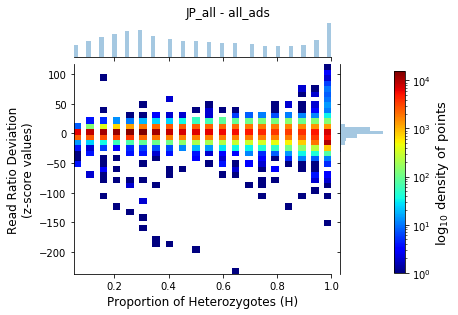

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i2_DF_all.pdf


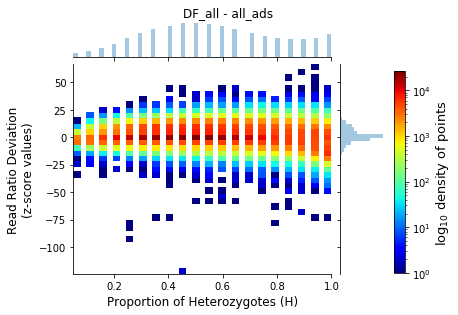

In [22]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i2'  # intersection
for sp,df in all_ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=f'{sp} - all_ads', bins=39,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}.pdf'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i2_JP_all_ylim.pdf


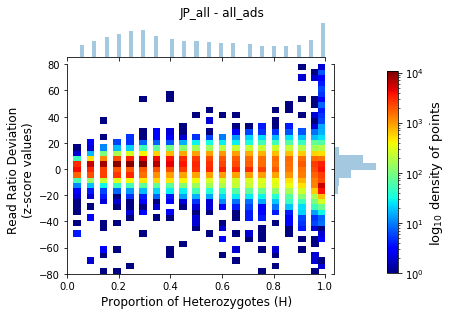

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i2_DF_all_ylim.pdf


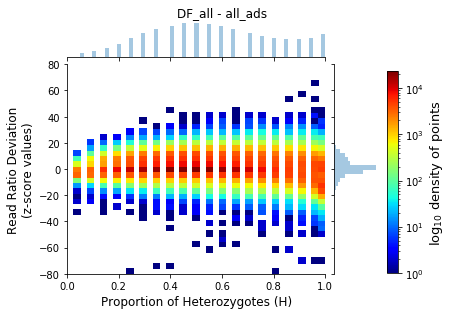

In [23]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i2'  # intersection
for sp,df in all_ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=f'{sp} - all_ads',
                   xlim=(0,1), ylim=(-80,80), bins=39,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}_ylim.pdf'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i2_JP_all_ylim2.pdf


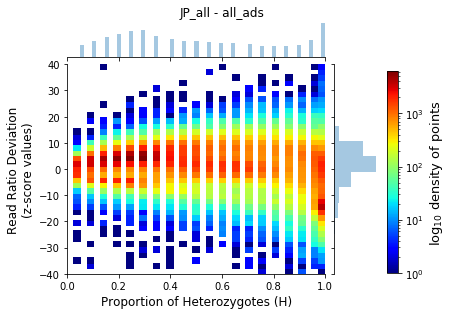

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i2_DF_all_ylim2.pdf


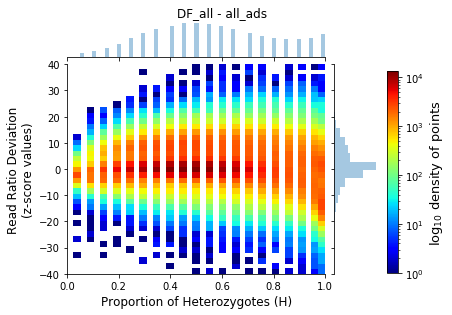

In [24]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i2'  # intersection
for sp,df in all_ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=f'{sp} - all_ads',
                   xlim=(0,1),ylim=(-40,40), bins=39,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}_ylim2.pdf'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-H_i2_JP_all.pdf


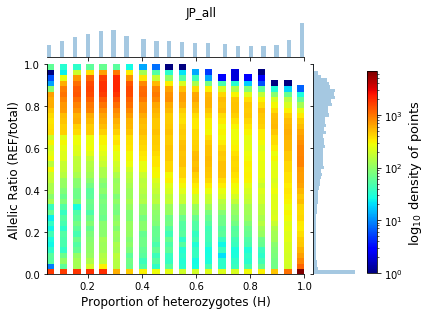

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-H_i2_DF_all.pdf


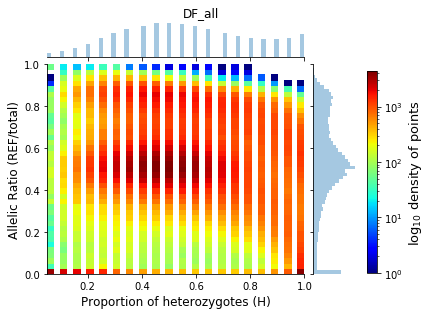

In [25]:
#PLOT RATIO AGAINST HETEROZYGOSITY
ixn = 'i2'  # intersection
for sp,df in all_ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['HET_REF_AD-div-HET_DP'],xlab='Proportion of heterozygotes (H)',
                   ylab='Allelic Ratio (REF/total)', title=sp, bins=39,
                   saveloc=op.join(figdir, f'AR-vs-H_{ixn}_{sp}.pdf'))

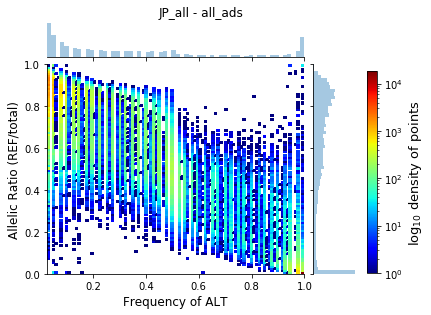

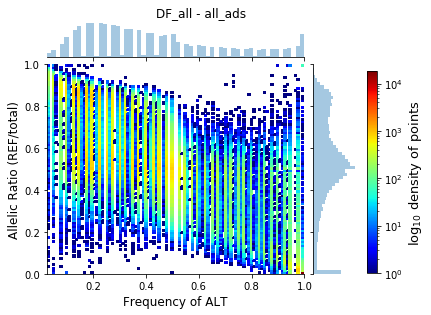

In [26]:
# RR vs AF
ixn = 'i2'  # intersection
for sp,df in all_ads.items():
    makesweetgraph(x=df['AF'],y=df['HET_REF_AD-div-HET_DP'],ylab='Allelic Ratio (REF/total)',
                   xlab='Frequency of ALT', title=f'{sp} - all_ads')

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-ALT_i2_JP_all.pdf


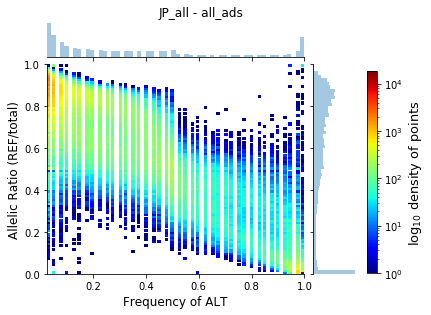

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-ALT_i2_DF_all.pdf


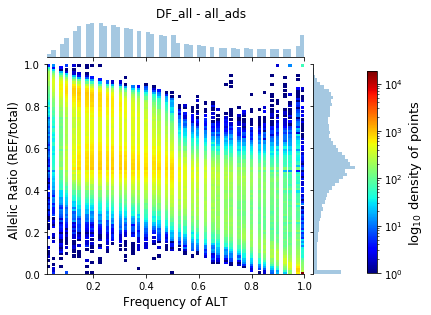

In [27]:
# RR vs realfreq
ixn = 'i2'  # intersection
for sp,df in all_ads.items():
    makesweetgraph(x=df['realfreq'],y=df['HET_REF_AD-div-HET_DP'],ylab='Allelic Ratio (REF/total)',
                   xlab='Frequency of ALT', title=f'{sp} - all_ads',
                   saveloc=op.join(figdir, f'AR-vs-ALT_{ixn}_{sp}.pdf'))

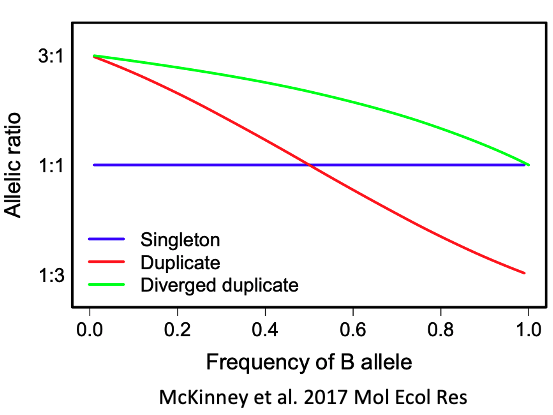

In [28]:
# show expectations from McKinney et al 2017 Mol Ecol Res
Image(filename=op.join(methodsdir, 'figs/all-ratio_vs_ALT-freq.png'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/H-vs-ALT_i2_JP_all.pdf


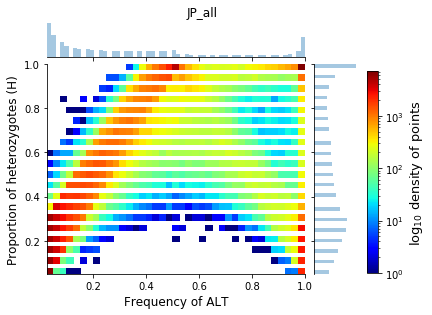

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/H-vs-ALT_i2_DF_all.pdf


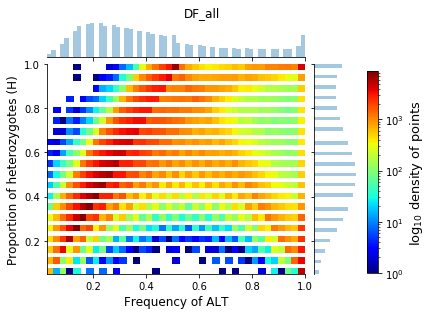

In [29]:
# AF vs hetPerc
ixn = 'i2'  # intersection
for sp,df in all_ads.items():
    makesweetgraph(x=df['realfreq'],y=df['hetPerc'],
                   ylab='Proportion of heterozygotes (H)',xlab='Frequency of ALT', title=sp, bins=39,
                   saveloc=op.join(figdir, f'H-vs-ALT_{ixn}_{sp}.pdf'))

# <center> GATK indSeq data as a whole

<center> this is baseline-filtered GATK output before filtering for intersection with poolSeq or megaSNPs

# load data

In [30]:
# get the raw file names and read in the data
sppfiles = {'gatk':{'JP': '/data/projects/pool_seq/non-pangenome/gatk_diploid_testdata/JP_i101-gatk/filtered_snps/JP_i101_filtered_concatenated_snps_max-missing_table_biallelic-only_translated.txt',
                   'DF': '/data/projects/pool_seq/non-pangenome/gatk_diploid_testdata/DF_i52-gatk/filtered_snps/DF_i52_filtered_concatenated_snps_max-missing_table_biallelic-only_p000_translated.txt'}}
dfs = {}
for method,spp in sppfiles.items():
    for sp,file in spp.items():
        dfs[sp] = pd.read_table(file)
        print(sp, dfs[sp].shape)
        dfs[sp] = dfs[sp][~dfs[sp]['ALT'].str.contains('+',regex=False)]  # remove noREF snps
        locuscol = 'unstitched_locus' if 'unstitched_locus' in dfs[sp].columns else 'locus'
        dfs[sp].index = dfs[sp][locuscol].tolist()
        print(sp, dfs[sp].shape, min(dfs[sp]['AF']), max(dfs[sp]['AF']))
dfs[sp].head()

JP (378713, 117)
JP (377080, 117) 0.025 1.0
DF (1527720, 117)
DF (1526554, 117) 0.025 1.0


,CHROM,POS,REF,ALT,AF,DP,QD,FS,MQ,MQRankSum,ReadPosRankSum,TYPE,FILTER,DF_52_20_cap3_kit1.AD,DF_52_20_cap3_kit1.DP,DF_52_20_cap3_kit1.GQ,DF_52_20_cap3_kit1.GT,DF_52_20_cap3_kit1.SB,DF_52_21_cap3_kit1.AD,DF_52_21_cap3_kit1.DP,DF_52_21_cap3_kit1.GQ,DF_52_21_cap3_kit1.GT,DF_52_21_cap3_kit1.SB,DF_52_22_cap3_kit1.AD,DF_52_22_cap3_kit1.DP,DF_52_22_cap3_kit1.GQ,DF_52_22_cap3_kit1.GT,DF_52_22_cap3_kit1.SB,DF_52_23_cap3_kit1.AD,DF_52_23_cap3_kit1.DP,DF_52_23_cap3_kit1.GQ,DF_52_23_cap3_kit1.GT,DF_52_23_cap3_kit1.SB,DF_52_24_cap3_kit1.AD,DF_52_24_cap3_kit1.DP,DF_52_24_cap3_kit1.GQ,DF_52_24_cap3_kit1.GT,DF_52_24_cap3_kit1.SB,DF_52_25_cap3_kit1.AD,DF_52_25_cap3_kit1.DP,DF_52_25_cap3_kit1.GQ,DF_52_25_cap3_kit1.GT,DF_52_25_cap3_kit1.SB,DF_52_26_cap4_kit1.AD,DF_52_26_cap4_kit1.DP,DF_52_26_cap4_kit1.GQ,DF_52_26_cap4_kit1.GT,DF_52_26_cap4_kit1.SB,DF_52_27_cap4_kit1.AD,DF_52_27_cap4_kit1.DP,...,DF_52_30_cap4_kit1.SB,DF_52_31_cap4_kit1.AD,DF_52_31_cap4_kit1.DP,DF_52_31_cap4_kit1.GQ,DF_52_31_cap4_kit1.GT,DF_52_31_cap4_kit1.SB,DF_52_32_cap4_kit1.AD,DF_52_32_cap4_kit1.DP,DF_52_32_cap4_kit1.GQ,DF_52_32_cap4_kit1.GT,DF_52_32_cap4_kit1.SB,DF_52_33_cap5_kit1.AD,DF_52_33_cap5_kit1.DP,DF_52_33_cap5_kit1.GQ,DF_52_33_cap5_kit1.GT,DF_52_33_cap5_kit1.SB,DF_52_34_cap5_kit1.AD,DF_52_34_cap5_kit1.DP,DF_52_34_cap5_kit1.GQ,DF_52_34_cap5_kit1.GT,DF_52_34_cap5_kit1.SB,DF_52_35_cap5_kit1.AD,DF_52_35_cap5_kit1.DP,DF_52_35_cap5_kit1.GQ,DF_52_35_cap5_kit1.GT,DF_52_35_cap5_kit1.SB,DF_52_36_cap5_kit1.AD,DF_52_36_cap5_kit1.DP,DF_52_36_cap5_kit1.GQ,DF_52_36_cap5_kit1.GT,DF_52_36_cap5_kit1.SB,DF_52_37_cap5_kit1.AD,DF_52_37_cap5_kit1.DP,DF_52_37_cap5_kit1.GQ,DF_52_37_cap5_kit1.GT,DF_52_37_cap5_kit1.SB,DF_52_38_cap5_kit1.AD,DF_52_38_cap5_kit1.DP,DF_52_38_cap5_kit1.GQ,DF_52_38_cap5_kit1.GT,DF_52_38_cap5_kit1.SB,DF_52_39_cap5_kit1.AD,DF_52_39_cap5_kit1.DP,DF_52_39_cap5_kit1.GQ,DF_52_39_cap5_kit1.GT,DF_52_39_cap5_kit1.SB,locus,unstitched_chrom,unstitched_pos,unstitched_locus
>jcf7190000000004-54533,Scaffold_1,159797,G,C,0.025,220,6.57,2.808,57.83,-0.967,-0.015,SNP,PASS,"15,0",15.0,36.0,G/G,NaN,"20,0",20.0,57.0,G/G,NaN,"11,0",11.0,30.0,G/G,NaN,"10,0",10.0,27.0,G/G,NaN,"11,0",11.0,27.0,G/G,NaN,"5,0",5.0,15.0,./.,NaN,"13,0",13.0,39.0,G/G,NaN,"8,0",8.0,...,NaN,"7,0",7.0,21.0,G/G,NaN,"11,0",11.0,33.0,G/G,NaN,"11,0",11.0,33.0,G/G,NaN,"11,0",11.0,30.0,G/G,NaN,"13,0",13.0,36.0,G/G,NaN,"8,0",8.0,24.0,G/G,NaN,"11,0",11.0,33.0,G/G,NaN,"16,0",16.0,48.0,G/G,NaN,"14,0",14.0,42.0,G/G,NaN,Scaffold_1-159797,>jcf7190000000004,54533,>jcf7190000000004-54533
>jcf7190000000004-54540,Scaffold_1,159804,A,G,0.500,214,23.27,5.020,59.88,0.000,-0.285,SNP,PASS,"7,8",15.0,99.0,A/G,NaN,"9,10",19.0,99.0,A/G,NaN,"6,5",11.0,99.0,A/G,NaN,"8,0",8.0,24.0,A/A,NaN,"0,10",10.0,30.0,G/G,NaN,"0,5",5.0,15.0,./.,NaN,"6,8",14.0,99.0,A/G,NaN,"8,0",8.0,...,NaN,"0,7",7.0,21.0,G/G,NaN,"5,7",12.0,99.0,A/G,NaN,"4,9",13.0,99.0,A/G,NaN,"4,7",11.0,99.0,A/G,NaN,"8,5",13.0,99.0,A/G,NaN,"9,0",9.0,10.0,./.,NaN,"4,6",10.0,99.0,A/G,NaN,"16,0",16.0,48.0,A/A,NaN,"0,11",11.0,33.0,G/G,NaN,Scaffold_1-159804,>jcf7190000000004,54540,>jcf7190000000004-54540
>jcf7190000000004-54587,Scaffold_1,159851,C,T,0.275,206,16.29,3.218,60.00,0.000,0.000,SNP,PASS,"6,6",12.0,99.0,C/T,NaN,"7,9",16.0,99.0,C/T,NaN,"11,0",11.0,30.0,C/C,NaN,"3,6",9.0,99.0,C|T,NaN,"8,0",8.0,15.0,./.,NaN,"5,0",5.0,12.0,./.,NaN,"10,5",15.0,99.0,C/T,NaN,"2,3",5.0,...,NaN,"7,0",7.0,18.0,./.,NaN,"5,5",10.0,99.0,C/T,NaN,"9,7",16.0,99.0,C/T,NaN,"6,4",10.0,99.0,C/T,NaN,"4,7",11.0,99.0,C/T,NaN,"9,0",9.0,27.0,C/C,NaN,"11,0",11.0,33.0,C/C,NaN,"10,5",15.0,99.0,C|T,NaN,"12,0",12.0,36.0,C/C,NaN,Scaffold_1-159851,>jcf7190000000004,54587,>jcf7190000000004-54587
>jcf7190000000004-54589,Scaffold_1,159853,C,T,0.850,208,30.18,4.404,59.90,0.000,-1.085,SNP,PASS,"0,12",12.0,36.0,T/T,NaN,"0,15",15.0,45.0,T/T,NaN,"0,11",11.0,33.0,T/T,NaN,"3,6",9.0,99.0,C|T,NaN,"0,8",8.0,24.0,T/T,NaN,"0,5",5.0,15.0,./.,NaN,"0,15",15.0,45.0,T/T,NaN,"2,3",5.0,...,NaN,"0,7",7.0,21.0,T/T,NaN,"0,10",10.0,30.0,T/T,NaN,"0,16",16.0,

In [31]:
# how many intersecting?
print('sp mega total_mega')
print('------------------')
full_inters = {}
for sp in ['JP', 'DF']:
    full_inters[sp] = list(set(dfs[sp].index.tolist()).intersection(megasnps[sp].index.tolist()))
    print(sp, len(full_inters[sp]), nrow(megasnps[sp]))

sp mega total_mega
------------------
JP 7408 32751
DF 293 398774


In [32]:
# I plotted the figs using full_inters, but this was basically the same as the intersection figs above. ...
# ... (7006 JP intersection, 248 DF intesecting). So I decided to just plot all SNPs here

In [33]:
# for each of the diploid datasets, calculate read ratio stats *for loci overlapping with megaSNPS* ...
# ... and write to file, capture file in list(outs)
full_outs = []
for sp in ['JP', 'DF']:
    outfile = op.join(thirddir, f'full-AD_depths-{sp}.txt')
#     if op.exists(outfile):
#         full_outs.append(outfile)
#     else:
    full_outs.append(get_het_depths(dfs[sp], dfs[sp].index, outfile))
full_outs

100%|██████████| 1526554/1526554 [05:16<00:00, 4816.50it/s]


['/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/full-AD_depths-JP.txt',
 '/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/full-AD_depths-DF.txt']

In [34]:
full_outs = ['/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/full-AD_depths-JP.txt',
 '/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/full-AD_depths-DF.txt']

In [35]:
# read in the output from list(outs)
full_ads = {}
for out in full_outs:
    sp = out.split("-")[-1].split('.txt')[0]
    full_ads[sp] = pd.read_table(out)
    full_ads[sp].index = full_ads[sp]['locus_ID'].tolist()
    print(sp, full_ads[sp].shape)

JP (372749, 13)
DF (1519990, 13)


In [36]:
# get z scores for each species
for sp,df in full_ads.items():
    df = get_realfreqs(get_z_scores(df))
full_ads[sp].head(2)

,CHROM,POS,locus_ID,AF,HET_REF_AD,HET_ALT_AD,HET_REF_AD-div-HET_DP,num_hets,num_samples,TOTAL_REF_AD,TOTAL_ALT_AD,TOTAL_REF_AD-div-TOTAL_DP,TOTAL_ALT_AD-div-TOTAL_DP,HET-TOTAL_AD,hetPerc,std,z,MAF,realfreq
>jcf7190000000004-54533,>jcf7190000000004,54533,>jcf7190000000004-54533,0.025,11,3,0.785714,2,20,11,3,0.785714,0.214286,14,0.10,1.870829,2.138090,0.025,0.025
>jcf7190000000004-54540,>jcf7190000000004,54540,>jcf7190000000004-54540,0.500,71,74,0.489655,13,20,71,74,0.489655,0.510345,145,0.65,6.020797,-0.249136,0.500,0.500


(372749, 19)
Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i3_JP.pdf


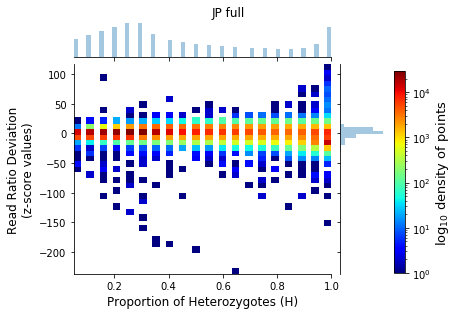

(1519990, 19)
Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i3_DF.pdf


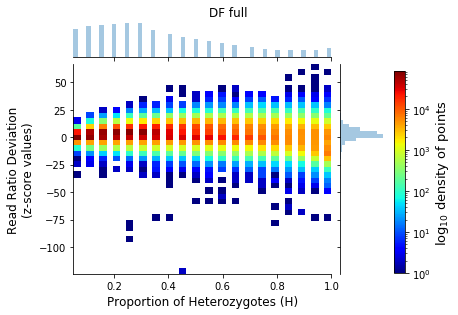

In [37]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i3'  # intersection
for sp,df in full_ads.items():
    print(df.shape)
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=f'{sp} full', bins=39,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}.pdf'))

(372749, 19)
Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i3_JP_ylim.pdf


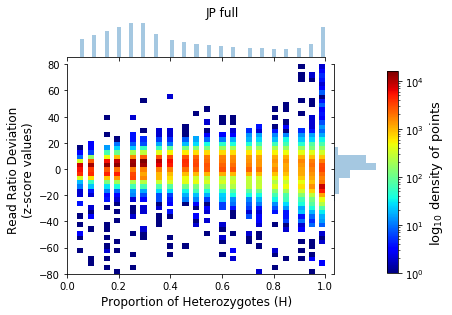

(1519990, 19)
Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i3_DF_ylim.pdf


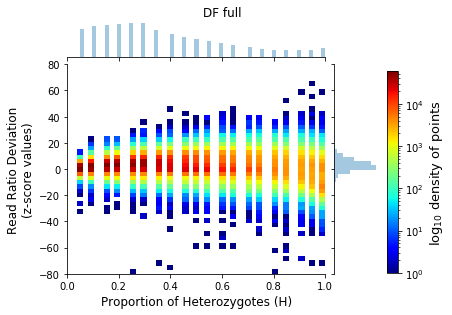

In [38]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i3'  # intersection
for sp,df in full_ads.items():
    print(df.shape)
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=f'{sp} full',
                   xlim=(0,1), ylim=(-80,80), bins=49,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}_ylim.pdf'))

(372749, 19)
Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i3_JP_ylim2.pdf


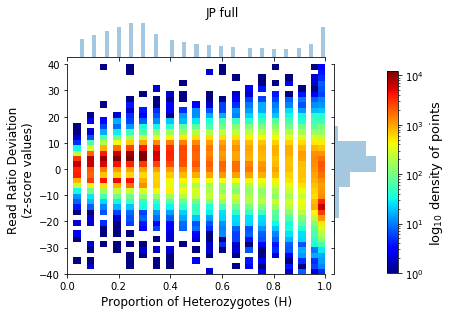

(1519990, 19)
Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/Z-vs-H_i3_DF_ylim2.pdf


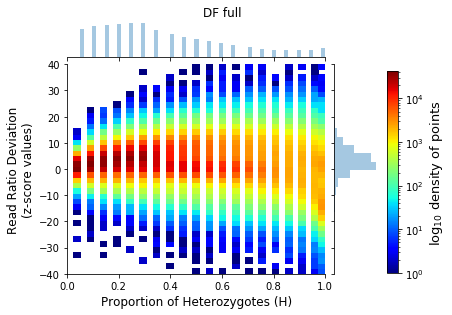

In [39]:
#PLOT READ-RATIO DEVIATION (D) AGAINST HETEROZYGOSITY
ixn = 'i3'  # intersection
for sp,df in full_ads.items():
    print(df.shape)
    makesweetgraph(x=df['hetPerc'],y=df['z'],ylab='Read Ratio Deviation\n(z-score values)',
                   xlab='Proportion of Heterozygotes (H)', title=f'{sp} full',
                   xlim=(0,1), ylim=(-40,40), bins=39,
                   saveloc=op.join(figdir, f'Z-vs-H_{ixn}_{sp}_ylim2.pdf'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-H_i3_JP.pdf


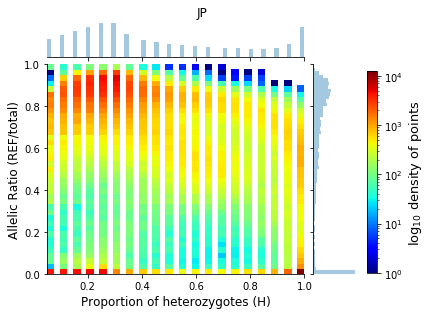

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-H_i3_DF.pdf


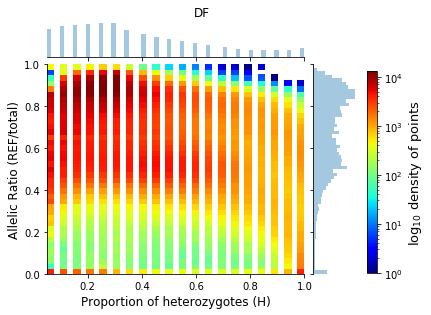

In [40]:
#PLOT RATIO AGAINST HETEROZYGOSITY
ixn = 'i3'  # intersection
for sp,df in full_ads.items():
    makesweetgraph(x=df['hetPerc'],y=df['HET_REF_AD-div-HET_DP'],xlab='Proportion of heterozygotes (H)',
                   ylab='Allelic Ratio (REF/total)', title=sp, bins=39,
                   saveloc=op.join(figdir, f'AR-vs-H_{ixn}_{sp}.pdf'))

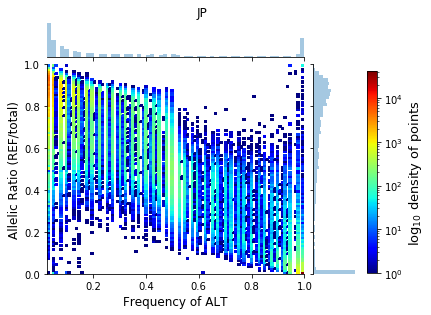

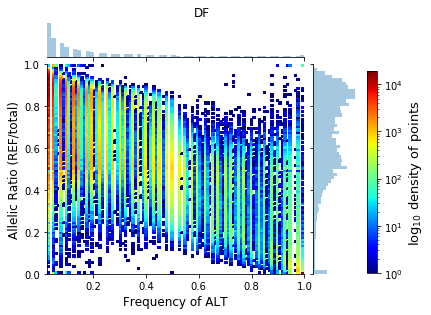

In [41]:
# RR vs AF
for sp,df in full_ads.items():
    makesweetgraph(x=df['AF'],y=df['HET_REF_AD-div-HET_DP'],ylab='Allelic Ratio (REF/total)',xlab='Frequency of ALT', title=sp)

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-ALT_i3_JP.pdf


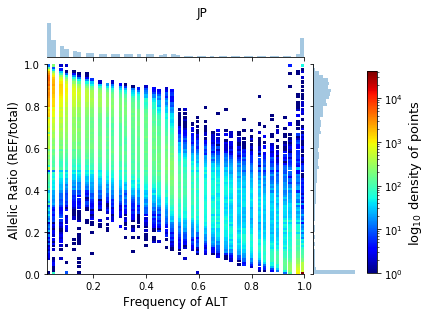

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/AR-vs-ALT_i3_DF.pdf


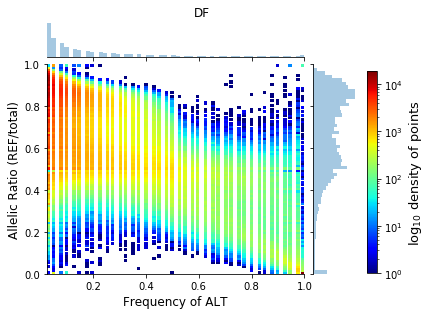

In [42]:
# RR vs realfreq
ixn = 'i3'  # intersection
for sp,df in full_ads.items():
    makesweetgraph(x=df['realfreq'],y=df['HET_REF_AD-div-HET_DP'],
                   ylab='Allelic Ratio (REF/total)',xlab='Frequency of ALT', title=sp,
                   saveloc=op.join(figdir, f'AR-vs-ALT_{ixn}_{sp}.pdf'))

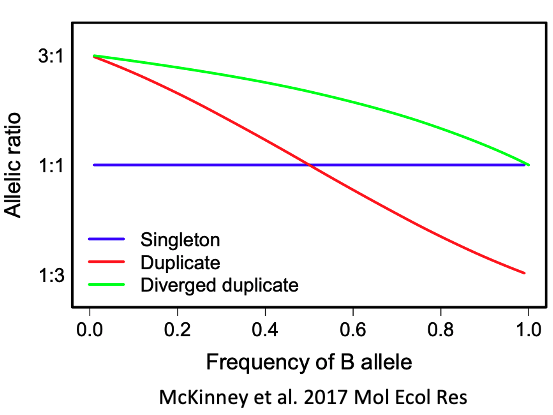

In [43]:
# show expectations from McKinney et al 2017 Mol Ecol Res
Image(filename=op.join(methodsdir, 'figs/all-ratio_vs_ALT-freq.png'))

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/H-vs-ALT_i3_JP.pdf


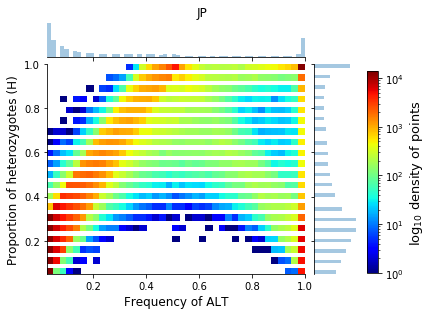

Saved to:  /data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/updated_figures/H-vs-ALT_i3_DF.pdf


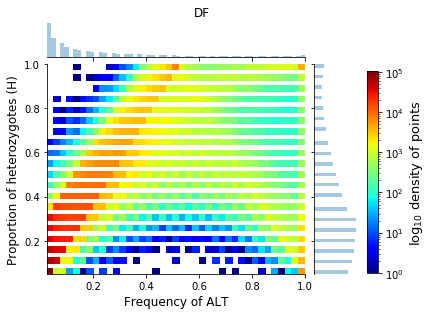

In [44]:
# AF vs hetPerc
ixn = 'i3'  # intersection
for sp,df in full_ads.items():
    makesweetgraph(x=df['realfreq'],y=df['hetPerc'],
                   ylab='Proportion of heterozygotes (H)',xlab='Frequency of ALT', title=sp, bins=39,
                   saveloc=op.join(figdir, f'H-vs-ALT_{ixn}_{sp}.pdf'))